In [330]:
# Install dependency packges if you don't already have them

# !pip install requests beautifulsoup4
# !pip install pandas numpy
# !pip install xlrd'
# !pip install --upgrade jupyter
# !pip install geopandas
# !pip install geodatasets
# !pip install shapely

In [331]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
import geodatasets  
from shapely.geometry import Polygon

In [332]:
# get an object to represent the website contents

url = "https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

In [333]:
# this puts everything into the "data" folder of your current directory. So only run this when you are in your root project directory.
## this is just commented out to save time

# for link in soup.find_all('a'):
#     href = link.get('href')
#     if href and href.endswith('.xls'):
#         xls_url = urljoin(url, href)
#         print(f"Downloading: {xls_url}")  # Debug output
#         xls_response = requests.get(xls_url)
#         filename = os.path.join('data', os.path.basename(xls_url))
#         with open(filename, 'wb') as f:
#             f.write(xls_response.content)
# print("Downloaded all XLS files.")

In [334]:
def clean_acs_from_path(df_path):
    """
    Rename the columns in a ACS migration dataframe from excel. This does a lot of stuff:
        -removes header and footer (finds only cols starting with a US state name plus some other key ones)
        -renames and makes header all the state cols and leader cols (if there are any)

    Also make sure you have the states.txt file in your current directory. 

    :param df_path: the path to the xls file where the data is stored. make sure, if relative, you're starting in the right place
    :returns: a cleaned dataframe with col1 = where people currently lived, possibly some leader columns detailing the population of that state,
    and definitely two columns for every state showing where people moved from one year ago.
    """
    try:
        df = pd.read_excel(df_path, skiprows=6) #create the dataframe
        df.columns.values[0] = 'State'

        bad_col_list = [i for i in range(11, len(df.columns), 11)] ## every 11th column starting with 11th .. these are the copied "current residence" columns.
        df.drop(df.columns[bad_col_list], axis=1, inplace=True)

        new_names = [
            "Current Population",
            "Current Population MOE",
            "Same house 1 year ago",
            "Same house 1 year ago MOE",
            "Same state of residence 1 year ago",
            "Same state of residence 1 year ago MOE",
            "Total Inmigration",
            "Total Inmigration MOE"
        ]

        #not all of the sheets are formatted the same way so we have to wrap this in if else
        if df.columns.values[1] == "Unnamed: 1":
            # print("changing column values") #debug
            for i in range(len(new_names)):
                df.columns.values[i+1] = new_names[i]
        else:
            pass
        
        # get rid of all the rows not actually reflecting "states"
        # I have this saved in another txt file for easier editing
        with open("state_names.txt", "r") as f: 
            state_names = [line.strip() for line in f]

        df = df[df['State'].isin(state_names)] 

        # rename all the state sub columns (estimate v MOE)
        for state in state_names:
                if state in df.columns:
                    idx = df.columns.get_loc(state)
                    df.rename(columns={state: state, df.columns[idx + 1]: state + " MOE"}, inplace=True)
        return df
    except Exception as e:
        print(f"Error processing file {df_path}: {e}")
        return None

In [335]:
def acs_df_to_pure_state(df):
    """
    Trims the frame so now all we have is the state column and then all the _inflow_ from other states

    :returns: a dataframe with 1st col state and all other columns 'colx' are estimates for how many people currently 
    in state used to live in colx. 
    """
    with open("state_names.txt", "r") as f: 
            state_names = [line.strip() for line in f]
    state_names.insert(0, "State") # we want our original identifying column
    df = df.copy()
    df = df.filter(items=state_names)
    return df

In [336]:
# now we have our data downloaded, we explore the 2021 file:
df_path = "Data/State_to_State_Migrations_Table_2021.xls"
df = clean_acs_from_path(df_path)
df_pure = acs_df_to_pure_state(df) 
df_pure

,State,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,...,Utah,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,Total.1
2,United States2,42291,104481,62338,176783,841065,246177,96578,36471,469577,...,78976,275906,17261,269232,112329,36026,35164,1400401,19587,1474657
4,Alabama,12,NaN,1271,1338,3369,2070,532,43,22507,...,436,5382,21,1385,1477,315,0,12058,29,12621
5,Alaska,NaN,517,0,977,3808,922,0,339,2163,...,210,963,0,1840,110,0,89,3667,0,3872
6,Arizona,3586,1485,178,NaN,69432,10035,2705,1554,6748,...,8495,1835,0,21816,4788,123,1580,33388,57,34302
7,Arkansas,145,950,NaN,940,5600,4353,31,68,1655,...,21,1030,0,1876,716,75,643,5828,0,5828
8,California,3049,2710,2576,27449,NaN,20353,5189,1012,24692,...,6111,16881,778,40456,6455,707,1338,185811,1921,188700
10,Colorado,3692,2192,171,11880,33648,NaN,1773,643,18661,...,5767,6432,0,6608,3031,105,3413,25442,291,26224
11,Connecticut,0,0,38,661,6645,1181,NaN,488,6534,...,451,1536,393,665,0,19,0,15186,165,17015
12,Delaware,0,0,0,708,116,239,786,NaN,1650,...,0,2588,0,258,39,0,0,4445,0,4764
14,Florida,2938,15159,4804,6607,37464,18468,15801,4732,NaN,...,7284,29153,1499,9611,9909,3165,1758,121742,2274,137811


In [337]:
df.sort_values(by="Total Inmigration", ascending=False).head(11)

,State,Current Population,Current Population MOE,Same house 1 year ago,Same house 1 year ago MOE,Same state of residence 1 year ago,Same state of residence 1 year ago MOE,Total Inmigration,Total Inmigration MOE,Alabama,...,Wyoming,Wyoming MOE,Total.1,Total.1 MOE,Puerto Rico,Puerto Rico MOE,U.S. Island Area,U.S. Island Area MOE,Foreign Country,Foreign Country MOE
2,United States2,328464538,34090,286552923,190336,32577121,167671,7859837,75123,104481,...,35164,6515,1474657,34636,54669,7470,19587,4066,1400401,33711
14,Florida,21590684,8058,18571567,47265,2206566,41666,674740,25002,15159,...,1758,958,137811,11410,13795,4714,2274,1557,121742,9765
60,Texas,29170380,12760,25086829,71104,3315313,62222,591395,26127,9389,...,4424,2403,176843,15137,4180,1912,1618,1339,171045,15106
8,California,38833197,12214,34461724,53862,3749371,49440,433402,16802,2710,...,1338,704,188700,12292,968,597,1921,860,185811,12087
48,North Carolina,10446881,5346,9034306,35163,1032016,31433,336681,16849,3276,...,110,169,43878,5344,941,661,781,934,42156,5050
16,Georgia,10688429,6334,9243299,38980,1107180,34938,302512,17711,22228,...,20,34,35438,5067,1805,708,742,579,32891,4832
47,New York,19626300,8200,17583476,37829,1666707,37802,287249,11439,1930,...,0,217,88868,6675,2189,1269,95,148,86584,6576
63,Virginia,8557020,4817,7384723,29614,855269,26354,272693,12741,1878,...,444,320,44335,6304,2912,1593,279,273,41144,5997
6,Arizona,7202745,5156,6144045,29885,759450,24263,264948,14419,1485,...,1580,1242,34302,5615,857,764,57,96,33388,5544
54,Pennsylvania,12842522,5067,11452320,31938,1078336,27367,261831,13241,585,...,229,290,50035,7559,6249,2423,232,220,43554,6723


In [338]:
#commented out to save time; this takes a while and frankly is a little useless I think

# df_ind = df.set_index("State")
# sns.pairplot(df_ind)

Index(['State', 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
       'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky',
       'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan',
       'Minnesota', 'Missouri', 'Mississippi', 'Montana', 'North Carolina',
       'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico',
       'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington',
       'Wisconsin', 'West Virginia', 'Wyoming', 'Foreign Country',
       'U.S. Island Area', 'Total.1'],
      dtype='object')

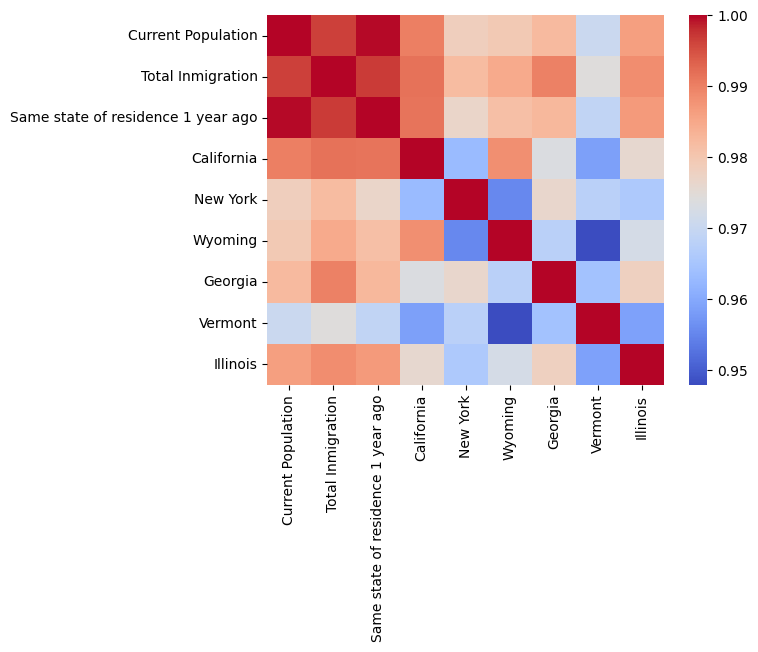

In [339]:
#seems like maybe there is a link between current population and inmigration. mess around with a correlation heat map...
df_ind = df.set_index("State")
df_ind = df_ind[['Current Population', 'Total Inmigration', 'Same state of residence 1 year ago', 'California', 'New York', 'Wyoming', 'Georgia', 'Vermont', 'Illinois' ]]
corr_mat = df_ind.corr()
sns.heatmap(corr_mat, cmap='coolwarm')

df_pure.columns
# this seems weird. all the correlations are very high. 
# I guess the more people are coming to your state from X, the more they are from Y, pretty much regardless??

In [340]:
df_pure

,State,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,...,Utah,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,Total.1
2,United States2,42291,104481,62338,176783,841065,246177,96578,36471,469577,...,78976,275906,17261,269232,112329,36026,35164,1400401,19587,1474657
4,Alabama,12,NaN,1271,1338,3369,2070,532,43,22507,...,436,5382,21,1385,1477,315,0,12058,29,12621
5,Alaska,NaN,517,0,977,3808,922,0,339,2163,...,210,963,0,1840,110,0,89,3667,0,3872
6,Arizona,3586,1485,178,NaN,69432,10035,2705,1554,6748,...,8495,1835,0,21816,4788,123,1580,33388,57,34302
7,Arkansas,145,950,NaN,940,5600,4353,31,68,1655,...,21,1030,0,1876,716,75,643,5828,0,5828
8,California,3049,2710,2576,27449,NaN,20353,5189,1012,24692,...,6111,16881,778,40456,6455,707,1338,185811,1921,188700
10,Colorado,3692,2192,171,11880,33648,NaN,1773,643,18661,...,5767,6432,0,6608,3031,105,3413,25442,291,26224
11,Connecticut,0,0,38,661,6645,1181,NaN,488,6534,...,451,1536,393,665,0,19,0,15186,165,17015
12,Delaware,0,0,0,708,116,239,786,NaN,1650,...,0,2588,0,258,39,0,0,4445,0,4764
14,Florida,2938,15159,4804,6607,37464,18468,15801,4732,NaN,...,7284,29153,1499,9611,9909,3165,1758,121742,2274,137811


In [341]:
#create a new column to see where most people are coming from.
df_ind = df_pure.set_index("State").drop(columns="Total.1")

#define these separately so they dont count for eachother 
inflow_max  = df_ind.idxmax(axis=1)
outflow_max = df_ind.drop("United States2").idxmax(axis=0)

df_ind['inflow_max'] = inflow_max
df_ind['outflow_max'] = outflow_max
df_ind


,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,inflow_max,outflow_max
State,,,,,,,,,,,,,,,,,,,,,
United States2,42291,104481,62338,176783,841065,246177,96578,36471,469577,238445,...,275906,17261,269232,112329,36026,35164,1400401,19587,Foreign Country,NaN
Alabama,12,NaN,1271,1338,3369,2070,532,43,22507,15873,...,5382,21,1385,1477,315,0,12058,29,Florida,Georgia
Alaska,NaN,517,0,977,3808,922,0,339,2163,1551,...,963,0,1840,110,0,89,3667,0,California,Idaho
Arizona,3586,1485,178,NaN,69432,10035,2705,1554,6748,3474,...,1835,0,21816,4788,123,1580,33388,57,California,California
Arkansas,145,950,NaN,940,5600,4353,31,68,1655,708,...,1030,0,1876,716,75,643,5828,0,Texas,Texas
California,3049,2710,2576,27449,NaN,20353,5189,1012,24692,9111,...,16881,778,40456,6455,707,1338,185811,1921,Foreign Country,Texas
Colorado,3692,2192,171,11880,33648,NaN,1773,643,18661,6419,...,6432,0,6608,3031,105,3413,25442,291,California,Texas
Connecticut,0,0,38,661,6645,1181,NaN,488,6534,1255,...,1536,393,665,0,19,0,15186,165,New York,Florida
Delaware,0,0,0,708,116,239,786,NaN,1650,130,...,2588,0,258,39,0,0,4445,0,Pennsylvania,Pennsylvania


In [342]:
df_ind.reset_index("State", inplace=True)
gdf = gpd.read_file("States_GeoData")
gdf = gdf.merge(df_ind, left_on='NAME', right_on='State')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,...,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,inflow_max,outflow_max
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...",...,3114,32,822,85,0,1801,9602,145,Foreign Country,Louisiana
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",...,29092,2117,6676,2443,497,110,42156,781,Foreign Country,South Carolina
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6...",...,1971,38,5754,2097,71,17,11543,46,Texas,Texas
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",...,NaN,483,6749,1152,5564,444,41144,279,Foreign Country,Florida
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,...",...,10202,36,279,271,NaN,0,2193,0,Virginia,Ohio


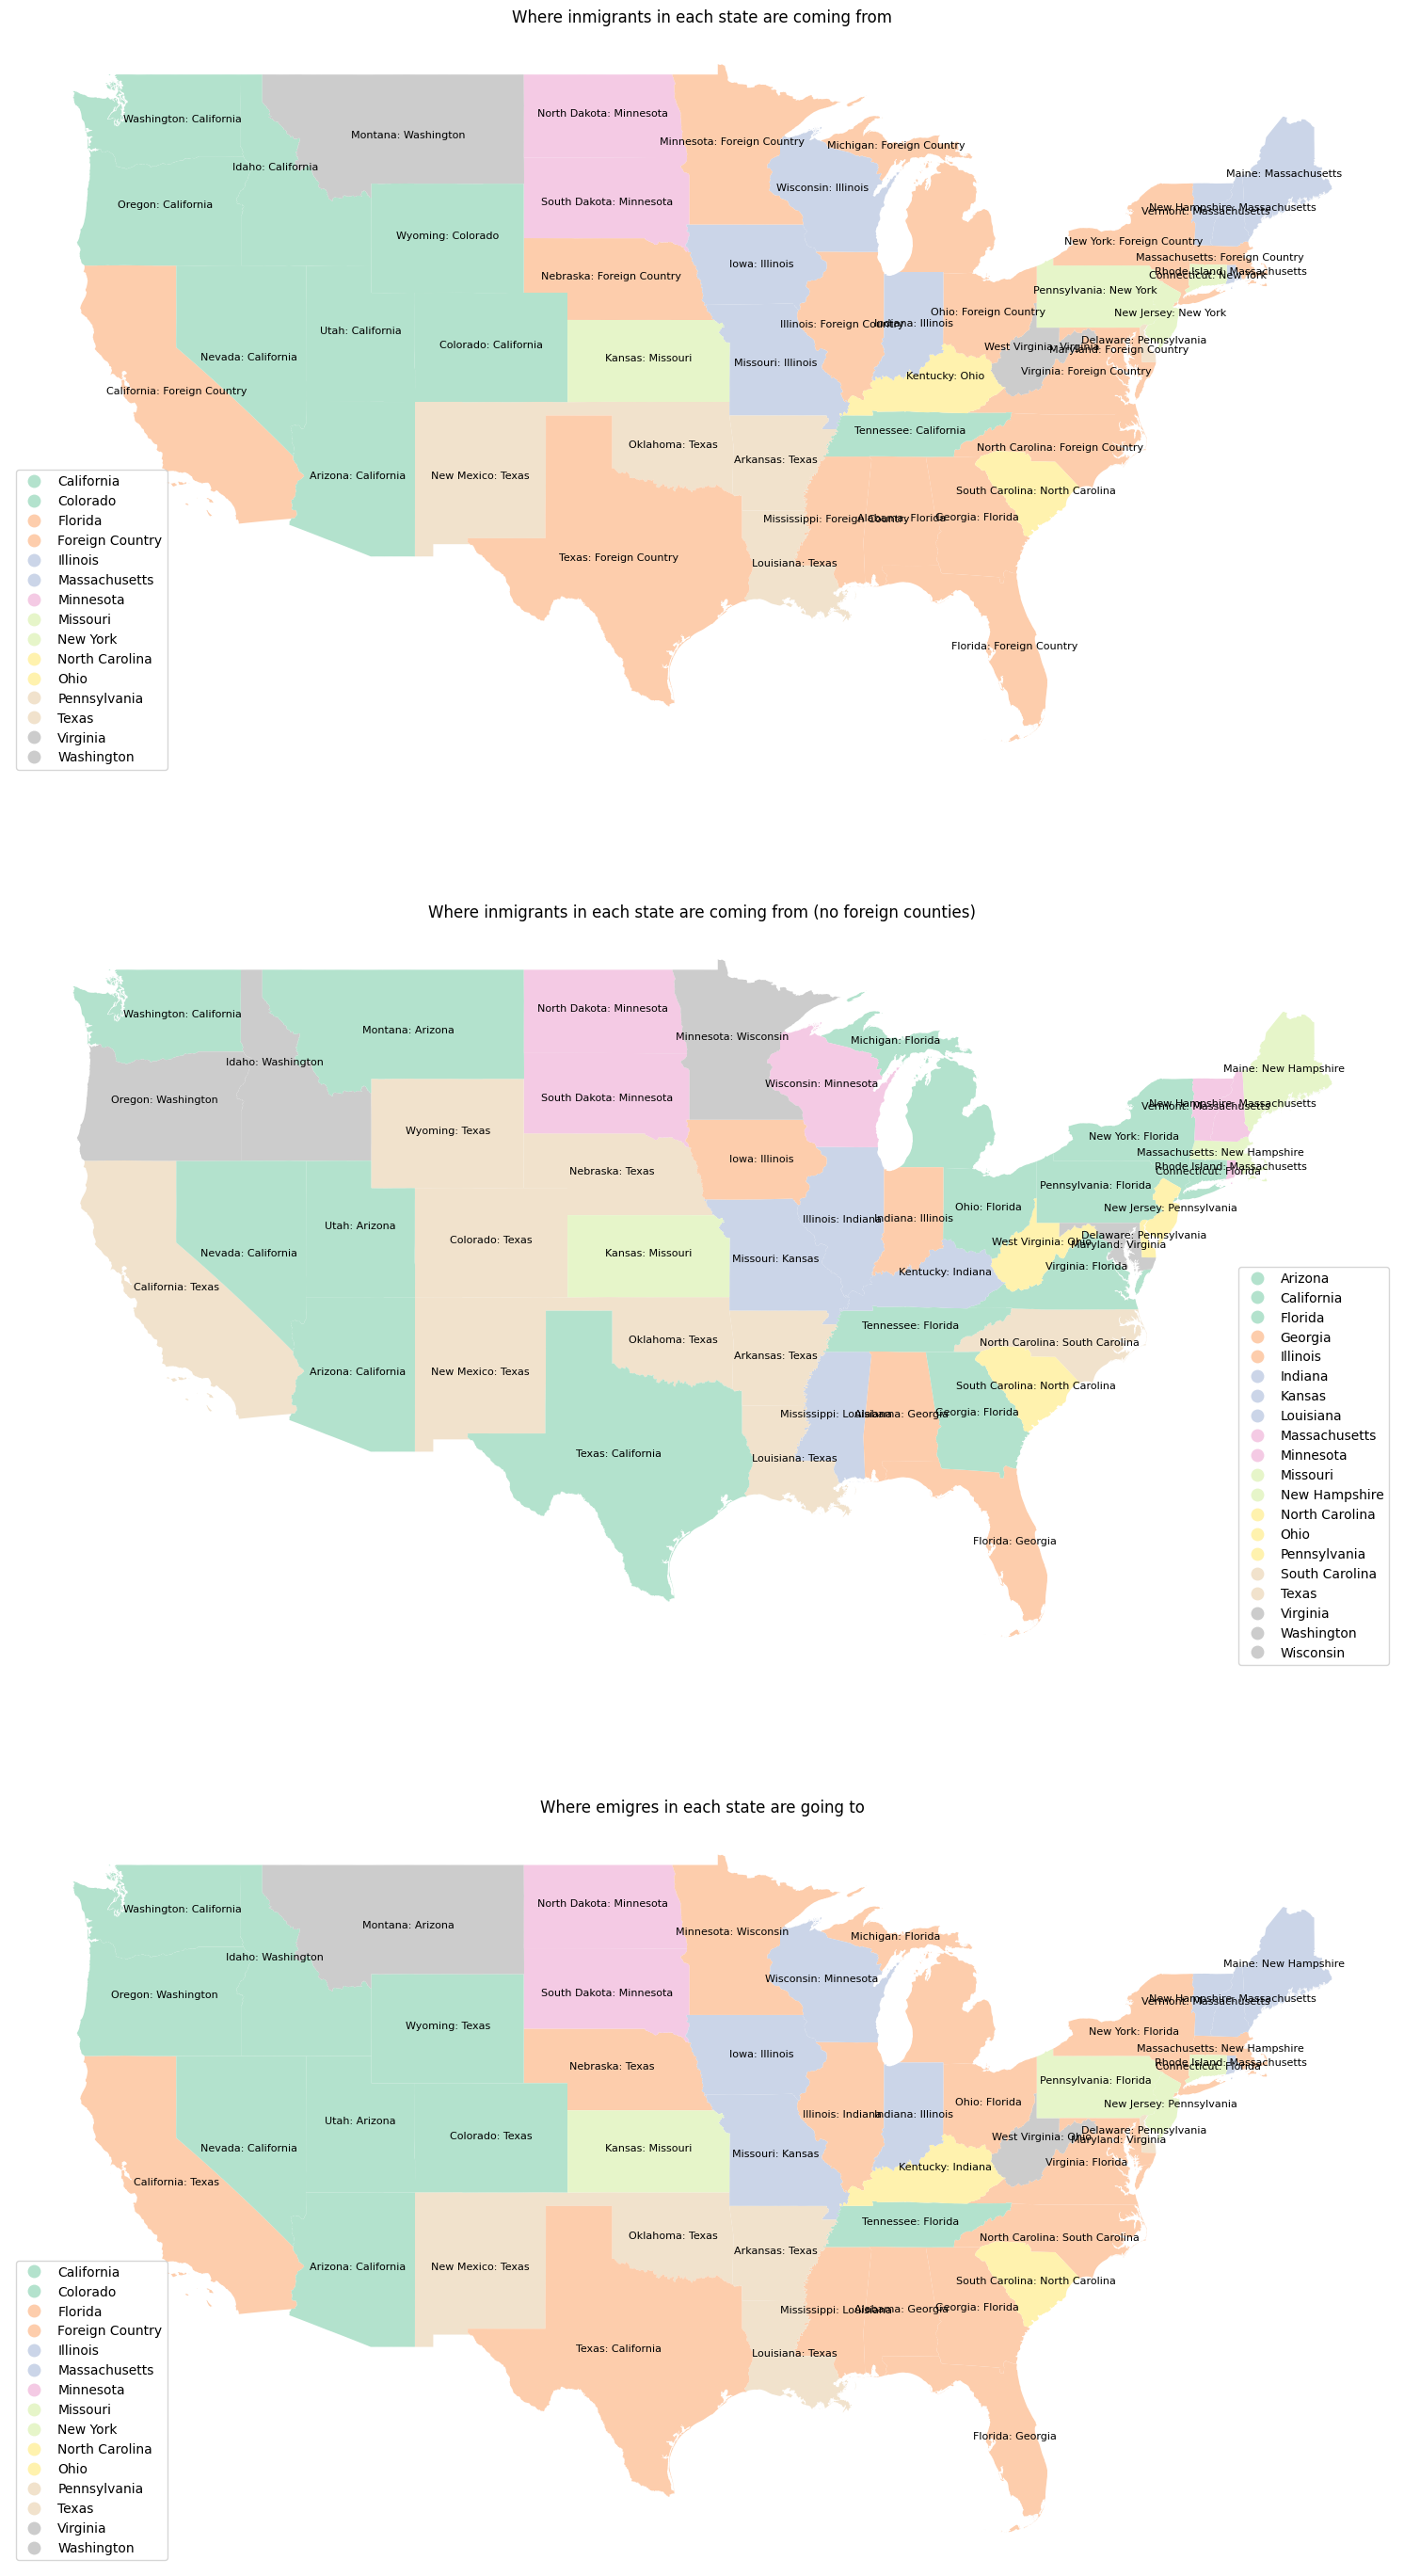

In [369]:
visframe = gdf.to_crs('EPSG:4326')

visframe = visframe[~visframe.State.isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico'])] ## just the continental. Note that the four non-continental are maybe the 
# most important to consider here... I'm just not that good at mapping to get them in



# create figure and axes for with Matplotlib for main map
fig, axes = plt.subplots(3, figsize=(40, 35))
# remove the axis box from the axes
axes = axes.flatten()
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')


#plot 1 has inflow max
visframe.plot(column='inflow_max', legend=True, ax=axes[0], cmap='Pastel2')

#add names on plot itself for clarity
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['inflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[0].text(point.x, point.y, label, fontsize=8, ha='center', color='black')

visframe.drop(columns='Foreign Country').plot(column='inflow_max', legend=True, ax=axes[2], cmap='Pastel2')
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[1].text(point.x, point.y, label, fontsize=8, ha='center', color='black')


#pllot three has outflow max 
visframe.plot(column='outflow_max', legend=True, ax=axes[1], cmap='Pastel2')

#add names on plot itself for clarity
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[2].text(point.x, point.y, label, fontsize=8, ha='center', color='black')

# set titles
axes[0].set_title("Where inmigrants in each state are coming from")
axes[1].set_title("Where inmigrants in each state are coming from (no foreign counties)")
axes[2].set_title("Where emigres in each state are going to")


plt.savefig("Figures/EDA/in_out_migration_plot_bystate_2021")


## only now do I realize that plot 2 and plot 3 are just mirror images of each other... 